In [1]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
import time
import logging

# Visulatisation
# %matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv

from shapely.geometry import LineString

import RANSAC

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

#### Load Data

In [2]:
# Load data.
tilecode = '2386_9699'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Valeriusplein/pointcloud/processed_' + tilecode + '.laz'
reduced_las_file = '../datasets/Valeriusplein/pointcloud/reduced_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Valeriusplein/ahn/'
# File with BGT building polygons.
bgt_building_file = '../datasets/Valeriusplein/bgt/bgt_buildings.csv'
# File with BGT road polygons.
bgt_road_file = '../datasets/Valeriusplein/bgt/bgt_roads.csv'
# File with <x,y> coordinates of pole-like objects.
bgt_pole_file = '../datasets/Valeriusplein/bgt/custom_poles.csv'
# File with <x,y> coordinates of street furniture objects.
bgt_street_furniture_file = '../datasets/Valeriusplein/bgt/bgt_street_furniture.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

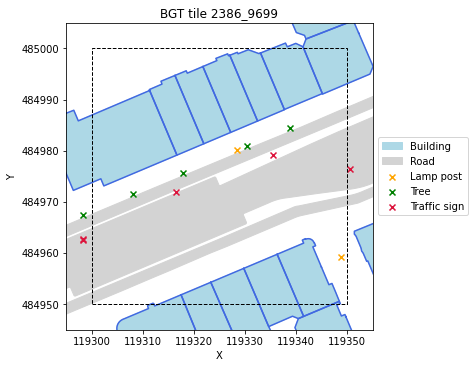

In [3]:
plot_utils.plot_bgt(tilecode, bgt_building_file, bgt_road_file, bgt_pole_file, bgt_street_furniture_file, padding=5)

## Cable Extraction: Feature-based

In [4]:
# true pointcloud
labeled_pointcloud = las_utils.read_las(las_file)
true_labels = labeled_pointcloud.label

# reduced pointcloud
pointcloud = las_utils.read_las(reduced_las_file)
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = pointcloud.label

# mask for unlabelled
mask = np.where(labels == 0)[0]

#### Step 1: Neighborhood Selection
Define the neighborhood of a point. Points will be used to calculate point features. (method: voxelization / distance-based / k-NN )

In [ ]:
# TODO: Code

In [7]:
# Voxelization
def voxelize(points, mask, voxel_size, logger=False):

    # Voxelize point cloud
    cloud = PyntCloud(pd.DataFrame(points[mask,:], columns=['x','y','z']))
    voxelgrid_id = cloud.add_structure("voxelgrid", size_x=voxel_size, size_y=voxel_size, size_z=voxel_size, regular_bounding_box=False)
    voxelgrid = cloud.structures[voxelgrid_id]
    if logger:
        print('Voxels per axis:',voxelgrid.x_y_z)
        print('Voxel size:',voxelgrid.shape)

    return voxelgrid

voxel_size = 1
voxel_grid = voxelize(points, mask, voxel_size)

In [8]:

a = np.vstack([voxel_grid.voxel_n,np.arange(0,voxel_grid.voxel_n.shape[0])]).T
a = a[a[:, 0].argsort()]
voxel_points = np.split(a[:, 1], np.unique(a[:, 0], return_index=True)[1][1:])
voxel_ids = np.unique(a[:, 0], return_index=True)[0]

# def b(voxel_grid):
#     df = pd.DataFrame({'voxels':voxel_grid.voxel_n})
#     voxel_points = df.groupby(by=df.voxels).groups


In [ ]:
def outlier_filter(points, mask=None, method='radius', voxelize=False, voxel_size=0.1, params=None):
    """
    The work of this region growing algorithm is based on the comparison
    of the angles between the points normals.
    The same can also be performed in Python using scipy.spatial.cKDTree
    with query_ball_tree or query.
    """

    # 1. Create mask and get ids of non-labelled
    label_mask = np.zeros(len(points),dtype=bool)
    if mask is None:
        mask = np.ones((len(points),), dtype=bool)
    mask_ids = np.where(mask)[0]

    # Convert point cloud
    coords = np.vstack((points[mask, 0], points[mask, 1], points[mask, 2])).transpose()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(coords)

    # Voxelize point cloud
    if voxelize: 
        pcd, _, trace_ids = pcd.voxel_down_sample_and_trace(voxel_size=voxel_size, min_bound=pcd.get_min_bound(), max_bound=pcd.get_max_bound())
        trace_ids = np.asarray(trace_ids)

    # Remove outliers
    if method == 'voxel_radius':

        if params is None:
            params = {'nb_points':1,'radius':0.5}
        _, non_outlier_ids = pcd.remove_radius_outlier(**params)

    elif method == 'sor':

        if params is None:
            params = {'nb_neighbors':4,'std_ratio':1}
        _, non_outlier_ids = pcd.remove_statistical_outlier(**params)

    outlier_mask = np.ones(len(coords), dtype=bool)
    if voxelize:
        non_outlier_ids = trace_ids[non_outlier_ids].flatten()
    outlier_mask[non_outlier_ids] = False
    label_mask[mask_ids] = outlier_mask

    return label_mask

In [ ]:
# Distance-based neighborhood


In [ ]:
# k-Nearest Neighbours neighbourhood

#### Step 2: Cadidate Cable Points
Use PCA to calculate geometrical features of a point and assess linearity.

In [ ]:
# TODO: Code

#### Step 3: Cluster Cable Points
Use euclidean distance clustering to cluster candidate cable points. (params: distance threshold)

In [ ]:
# TODO: Code

#### Step 4: Merge cable segments
Use cable segment properties to determine if cable segments belong to the same cable. Features which can be used: direction, height, and catenary fit.

In [5]:
# TODO: Code